# Imports

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1

2023-06-09 22:24:23.901325: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Get Data

Data is from kaggle https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities

Data folder in this directory looks like this : 20 files with name city-weekends(or weekdays).csv
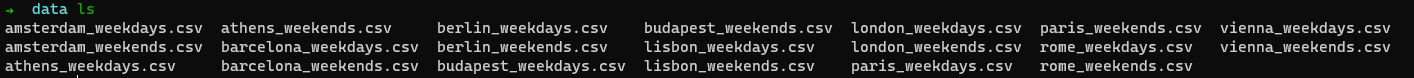

Make a concatenated dataframe with a new column 'filename'

In [2]:
globbed_files = glob.glob("data/*.csv")
data=[]
for csv in globbed_files:
    frame = pd.read_csv(csv)
    frame['filename'] = os.path.basename(csv)
    data.append(frame)

In [3]:
df = pd.concat(data)

Make new columns 'weekday_weekend' & 'city', as they are the information we need from the filenames

In [4]:
df['weekday_weekend'] = df['filename'].map(lambda x: x.split('_')[1].rstrip('.csv'))
df['city'] = df['filename'].map(lambda x: x.split('_')[0])

In [5]:
#removing unnecessary columns for this analysis
df = df.drop(columns=['multi','biz','filename', 'Unnamed: 0', 'attr_index','attr_index_norm', 'rest_index', 'rest_index_norm', 'lng', 'lat'])

In [6]:
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
0,332.048691,Entire home/apt,False,False,6.0,True,10.0,99.0,1,0.359372,0.352662,weekend,budapest
1,331.108709,Entire home/apt,False,False,6.0,False,9.0,98.0,2,0.929438,0.200219,weekend,budapest
2,243.925365,Entire home/apt,False,False,6.0,False,10.0,95.0,2,0.674318,0.314709,weekend,budapest
3,206.561075,Entire home/apt,False,False,5.0,True,10.0,99.0,2,1.338114,0.614128,weekend,budapest
4,238.285473,Entire home/apt,False,False,4.0,False,9.0,84.0,0,0.835635,0.175568,weekend,budapest


The target is 'realSum'('the total price of the Airbnb listing')

In [7]:
X = df.drop(columns='realSum')
y = df.realSum

In [8]:
np.average(y)

279.8795910937968

See the correlation matrix...

<AxesSubplot:>

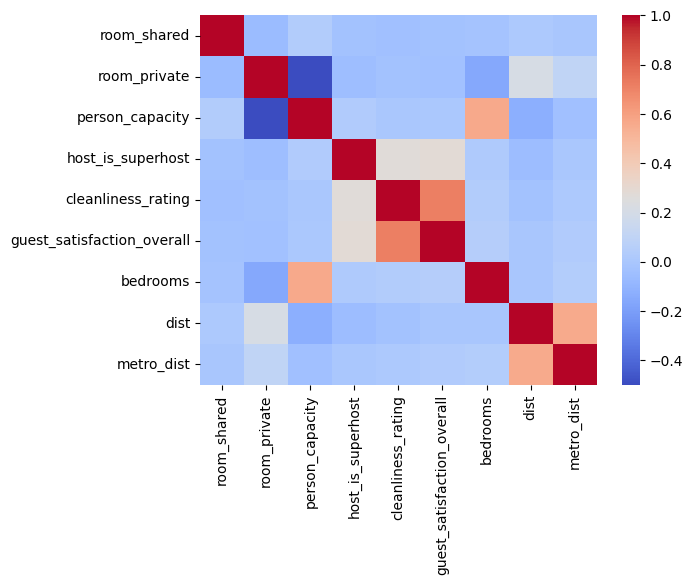

In [9]:
sns.heatmap(X.corr(), cmap='coolwarm')

room_private and person_capacity seem relatively highly correlated. --> let's drop 'room_private' (boolean) and keep 'person_capacity' (int) which contains more information. 

In [10]:
X = df.drop(columns=['realSum', 
                        'room_private'])

In [11]:
X_num_col = X.select_dtypes(include=['float', 'int']).columns
X_str_col = X.select_dtypes(include=['object', 'bool']).columns

## Train Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((41365, 11), (10342, 11), (41365,), (10342,))

## Preprocess numerical / categorical columns

In [13]:
num_transformer = StandardScaler()

cat_transformer = OneHotEncoder(handle_unknown='ignore', drop='if_binary')

preprocessor = ColumnTransformer([
    ('num_transformer', num_transformer, X_num_col),
    ('cat_transformer', cat_transformer, X_str_col)
])

preprocessor

ColumnTransformer(transformers=[('num_transformer', StandardScaler(),
                                 Index(['person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall',
       'bedrooms', 'dist', 'metro_dist'],
      dtype='object')),
                                ('cat_transformer',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 Index(['room_type', 'room_shared', 'host_is_superhost', 'weekday_weekend',
       'city'],
      dtype='object'))])

In [14]:
X_train_transformed = preprocessor.fit_transform(X_train)

print("X_train")
display(X_train.head())
print(X_train.shape)

print("X_train_processed")
display(pd.DataFrame(
    X_train_transformed, 
    columns=preprocessor.get_feature_names_out()
).head())
print(X_train_transformed.shape)

X_train


,room_type,room_shared,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
2461,Entire home/apt,False,2.0,False,9.0,90.0,1,5.534083,0.267605,weekend,paris
246,Private room,False,2.0,False,8.0,88.0,1,1.058492,0.358618,weekday,barcelona
416,Entire home/apt,False,5.0,False,9.0,91.0,1,0.931242,0.343834,weekday,budapest
943,Private room,False,2.0,False,9.0,98.0,1,3.576476,1.054139,weekend,amsterdam
1262,Entire home/apt,False,6.0,True,9.0,100.0,2,2.248307,0.196889,weekend,lisbon


(41365, 11)
X_train_processed


,num_transformer__person_capacity,num_transformer__cleanliness_rating,num_transformer__guest_satisfaction_overall,num_transformer__bedrooms,num_transformer__dist,num_transformer__metro_dist,cat_transformer__room_type_Entire home/apt,cat_transformer__room_type_Private room,cat_transformer__room_type_Shared room,cat_transformer__room_shared_True,...,cat_transformer__city_amsterdam,cat_transformer__city_athens,cat_transformer__city_barcelona,cat_transformer__city_berlin,cat_transformer__city_budapest,cat_transformer__city_lisbon,cat_transformer__city_london,cat_transformer__city_paris,cat_transformer__city_rome,cat_transformer__city_vienna
0,-0.895665,-0.411924,-0.291051,-0.253381,0.982629,-0.485021,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.895665,-1.464247,-0.514150,-0.253381,-0.893114,-0.378183,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.416586,-0.411924,-0.179501,-0.253381,-0.946446,-0.395537,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.895665,-0.411924,0.601346,-0.253381,0.162185,0.438281,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.187336,-0.411924,0.824445,1.337559,-0.394457,-0.568033,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


(41365, 22)


# Neural Network

In [15]:
model = models.Sequential()
    
model.add(layers.Dense(20, activation='relu', input_dim = X_train_transformed.shape[-1]))

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(5, activation='relu',  kernel_regularizer = L1(0.3)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam',
              loss='msle')

In [16]:
es = EarlyStopping(patience=10, restore_best_weights=True)
epochs = 20
batch_size = 16

history = model.fit(X_train_transformed, 
                    y_train,
                    validation_split=0.3,
                    epochs = epochs,         
                    batch_size = batch_size,
                    callbacks=[es],
                    verbose = 1)

Epoch 1/20
1810/1810 [==============================] - 6s 3ms/step - loss: 7.7141 - val_loss: 0.9815
Epoch 2/20
1810/1810 [==============================] - 6s 3ms/step - loss: 3.0115 - val_loss: 0.4427
Epoch 3/20
1810/1810 [==============================] - 6s 3ms/step - loss: 2.3693 - val_loss: 0.3343
Epoch 4/20
1810/1810 [==============================] - 6s 3ms/step - loss: 2.0217 - val_loss: 0.2478
Epoch 5/20
1810/1810 [==============================] - 6s 3ms/step - loss: 1.3283 - val_loss: 0.2760
Epoch 6/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.9323 - val_loss: 0.2170
Epoch 7/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.8502 - val_loss: 0.2104
Epoch 8/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.6117 - val_loss: 0.2450
Epoch 9/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.5622 - val_loss: 0.2002
Epoch 10/20
1810/1810 [==============================] - 6s 3ms/step - loss: 0.521

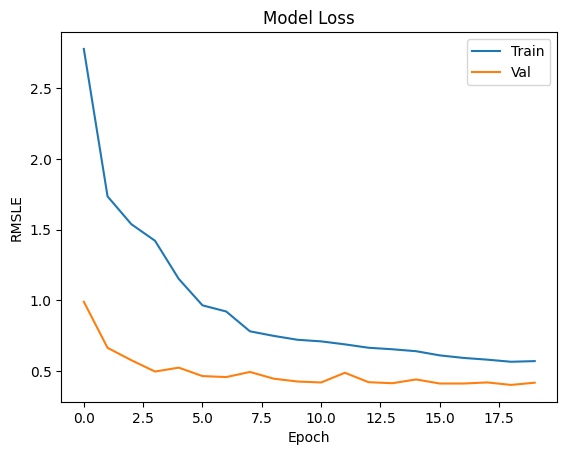

In [17]:
def plot_history(history):
    plt.plot(np.sqrt(history.history['loss']))
    plt.plot(np.sqrt(history.history['val_loss']))
    plt.title('Model Loss')
    plt.ylabel('RMSLE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()
    
plot_history(history)

In [18]:
X_test_transformed = preprocessor.transform(X_test)

In [19]:
res = model.evaluate(X_test_transformed, y_test)**0.5
print(f'RMSLE evaluated on test set is {round(res, 2)}')

324/324 [==============================] - 1s 2ms/step - loss: 0.1688
RMSLE evaluated on test set is 0.41


# How much would this airbnb cost according to the model?

In [20]:
random = np.random.randint(0,len(X_test), 1)

In [21]:
X_test_example = X_test.iloc[random]
X_test_example

,room_type,room_shared,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,weekday_weekend,city
1292,Private room,False,2.0,False,9.0,86.0,1,7.934426,1.727945,weekday,vienna


## Predicted price is...

In [22]:
example_transformed = preprocessor.transform(X_test_example)
model.predict(example_transformed)

1/1 [==============================] - 0s 101ms/step


array([[137.68843]], dtype=float32)

## True price is....

In [23]:
pd.DataFrame(y_test).iloc[random]

,realSum
1292,119.439964
